In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.


In [ ]:
import os
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import glob

row = 3
def prep_data(path):
  data = []
  labels = []
  filenames = [img for img in glob.glob(path)]
  for name in tqdm(filenames):
      df = pd.read_csv(name, header=None, error_bad_lines=False)
      # values = df.values[row - 1]
      values = df.values
      val = sequence.pad_sequences(values, maxlen=1000)
      data.append(val.tolist())
      split = name.split(os.sep)[-2]
      if split == 'control':
        labels.append(0)
      else:
        labels.append(1)

  data = np.asarray(data)
  labels = np.asarray(labels)
  return data,labels

In [ ]:
train_x, train_y = prep_data('/content/drive/My Drive/datasets/GB_dataset/train/*/*')

100%|██████████| 63/63 [03:30<00:00,  3.34s/it]


In [ ]:
val_x, val_y = prep_data('/content/drive/My Drive/datasets/GB_dataset/val/*/*')

100%|██████████| 23/23 [01:32<00:00,  4.03s/it]


In [ ]:
test_x, test_y = prep_data('/content/drive/My Drive/datasets/GB_dataset/test/*/*')

100%|██████████| 11/11 [00:30<00:00,  2.74s/it]


In [ ]:
print('Pad sequences (samples x time)')
maxlen = 1000
# train_x = sequence.pad_sequences(train_x, maxlen=maxlen)
# val_x = sequence.pad_sequences(val_x, maxlen=maxlen)
# test_x = sequence.pad_sequences(test_x, maxlen=maxlen)

Pad sequences (samples x time)


In [ ]:
model = Sequential()

batch_size = 32
embedding_dims = 5
filters = 80
kernel_size = 3
hidden_dims = 300
max_features = 8000

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
train_x.shape

(63, 14, 1000)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 5)           40000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 5)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 998, 80)           1280      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               24300     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 300)              

In [ ]:
slug = 'gazar_july_14_GB'
epochs = 10

In [ ]:
pathModelSave = '/content/drive/My Drive/saveModels/epi_eeg_conv1D'+'_nigiria_'+str(embedding_dims)+'_'+str(filters)+'_'+str(batch_size)+'_'+str(epochs)+'_'+slug+'_.hdf5'
pathToSaveCSV = '/content/drive/My Drive/saveModels/csv/epi_eeg_conv1D'+'_nigiria_'+str(embedding_dims)+'_'+str(filters)+'_'+str(batch_size)+'_'+str(epochs)+'_'+slug+'_.csv'

In [ ]:
import time
from keras.callbacks import ModelCheckpoint, CSVLogger

checkpoint = ModelCheckpoint(pathModelSave, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
csv_logger = CSVLogger(pathToSaveCSV, append=False, separator=',')

tic = time.clock()
history = model.fit(
          train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [checkpoint, csv_logger],
          validation_data=(val_x, val_y))
toc = time.clock()

In [ ]:
time = (toc-tic)/60
print("Total training time is: ", time)

Total training time is:  0.4500389666666668


In [ ]:
_, acc = model.evaluate(val_x, val_y, verbose=0)
print('validation acc> %.3f' % (acc* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

validation acc> 60.870 %, tt: 0.4500389666666668 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 3


In [ ]:
from keras.models import load_model
model_new = load_model(pathModelSave)

_train, acc_train = model_new.evaluate(train_x, train_y, verbose=0)
print('training acc> %.3f' % (acc_train* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

_val, acc_val = model_new.evaluate(val_x, val_y, verbose=0)
print('val..... acc> %.3f' % (acc_val* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

_test, acc_test = model_new.evaluate(test_x, test_y, verbose=0)
print('testing. acc> %.3f' % (acc_test* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


training acc> 74.603 %, tt: 0.4500389666666668 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 3
val..... acc> 78.261 %, tt: 0.4500389666666668 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 3
testing. acc> 63.636 %, tt: 0.4500389666666668 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 3


In [ ]:
# training acc> 74.603 %, tt: 0.4500389666666668 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 3
# val..... acc> 78.261 %, tt: 0.4500389666666668 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 3
# testing. acc> 63.636 %, tt: 0.4500389666666668 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 3
#------------------

In [ ]:
def convert_string_label(intLabel):
  Y = []
  length = len(intLabel)
  for i in range(length):
    if intLabel[i] == 0:
      Y.append("Control")
    elif intLabel[i] == 1:
      Y.append("Epilipsy")
  return Y

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


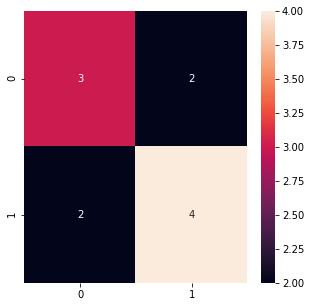

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_prediction = model_new.predict(test_x)
Y_pred_classes = []
for i in Y_prediction:
  if i[0] < 0.5:
    Y_pred_classes.append(0)
  else:
    Y_pred_classes.append(1)

Y_pred_classes = np.asarray(Y_pred_classes)
confusion_mtx = confusion_matrix(test_y, Y_pred_classes)

import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

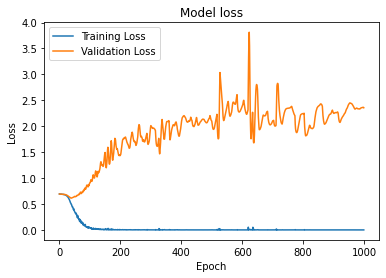

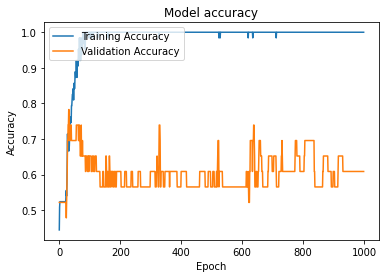

In [ ]:
# author Manoj kaushik
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [ ]:
# testing accuracies
import time
import os
import pandas as pd
import numpy as np
import sys
from keras.models import load_model
model = load_model(pathModelSave)

def predict_fun(filename, type, row):
  list = os.listdir(filename)
  list.sort()
  tic = time.clock()
  count_control = 0
  count = 0
  for name in list:
      count += 1
      file = os.path.join(filename, name)
      df = pd.read_csv(file, header = None, error_bad_lines = False)
      values = df.values[row - 1]
      data = []
      data.append(values.tolist())
      data = np.asarray(data)
      values = sequence.pad_sequences(data, maxlen = maxlen)
      p = model.predict(values)[0][0]
      if p < 0.5:
        count_control += 1
      #   print(count, '. ', name, ": Control predicted")
      # else :
      #   print(count, '. ', name, ": Epilipsy Pridicted")
  toc = time.clock()
  total_ele = len(list)
  print('total files of ' + str(type)+' are :', count, ' control predicted:', count_control, ' epilipsy predicted:', count - count_control, '| row',row)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
# total files of control are : 93  control predicted: 91  epilipsy predicted: 2 | row 8
# total files of epilipsy are : 128  control predicted: 21  epilipsy predicted: 107 | row 8

# total files of control are : 46  control predicted: 15  epilipsy predicted: 31 | row 2
# total files of epilipsy are : 51  control predicted: 14  epilipsy predicted: 37 | row 2

In [ ]:
# predict_fun('/content/drive/My Drive/datasets/EEGs_Nigeria_transposed/control/', 'control', 8)
# predict_fun('/content/drive/My Drive/datasets/EEGs_Nigeria_transposed/epilipsy/', 'epilipsy', 8)

In [ ]:
# predict_fun('/content/drive/My Drive/datasets/EEGs_Guinea-Bissau_classified/control/', 'control', 2)
# predict_fun('/content/drive/My Drive/datasets/EEGs_Guinea-Bissau_classified/epilipsy/', 'epilipsy', 2)